In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels, synchronize, channel_estimate,ofdm, encode, decode, preamble

cwd = os.getcwd()

In [2]:
#baisc parameter definition
filename = 'ofdm_tester'            #rememeber to change everytime

chirp_duration = 1
record_duration = 10
fs = 48000

DFT_LENGTH = 8192
CP_LENGTH = 1024
low_freq = 1000
high_freq = 10000

encode_method = 'qpsk'
double_chirp = False
known_ofdm = True

#define chirp used in the signal
chirp_range = [20,10000]
chirp = preamble.generate_chirp(chirp_duration, fs, low=chirp_range[0], high=chirp_range[1], silence_duration=0, double=double_chirp)

#define known ofdm symbol
seed_known = 0
known_ofdm = True
repeat_time = 5
if known_ofdm:
    known_ofdm_data = preamble.generate_known_ofdm(fs,DFT_LENGTH,CP_LENGTH,low_freq,high_freq,encode_method,repeat_time,seed_known)
else:
    known_ofdm_data = np.array([])
spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq,high_freq)

In [ ]:
#record and save
received_signal = audio.record(record_duration, fs)
audio.signal_to_wav(received_signal,fs,filename,"audio_files")

In [3]:
#load recorded signals
received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))

C:\Users\17927\AppData\Local\Temp/ipykernel_6208/2826014932.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))


In [4]:
#synchronize: convolve and find
start,convolved = synchronize.chirp_synchronize(received_signal,chirp_range, fs,duration=1)
event_end = np.array(synchronize.impulse_detect(convolved,fs,duration = 1,window_time=0.1,threshold=2))

In [5]:
#plot the convolved result
# plt.plot(convolved)
# for pos in event_end:
#     plt.axvline(x = pos, color = 'r')
# plt.show()

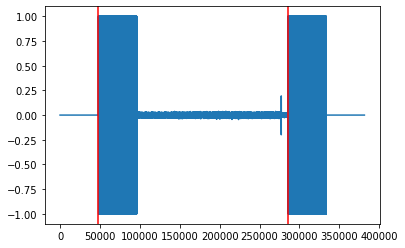

2 chirp events found, is that as expected? 


In [6]:
#plot found chirp in received signal
event_start = event_end - fs*chirp_duration
chirp_received = received_signal[event_start[0]:event_start[0]+chirp_duration*fs]   #taking only the first event for the time being

plt.plot(received_signal)
for pos in event_start:
    plt.axvline(x = pos, color = 'r')
plt.show()
event = event_start
print(str(len(event))+" chirp events found, is that as expected? ")

In [23]:
event = event+1     #manual correction for sync problem.... would be problematic in real channel

In [24]:
#estimate with known ofdm

known_ofdm_start = int(event[0] + fs*(chirp_duration)) #need to change accordingly
known_ofdm_end = known_ofdm_start + known_ofdm_data.size
received_known =received_signal[known_ofdm_start:known_ofdm_end]  #received ofdm part

#remove the first cyclic prefix manually then find discarded
received_known = received_known[CP_LENGTH:]
fft_known = ofdm.ofdm_to_fourier(received_known[:], DFT_LENGTH, cp_length=0) 
discarded_known = ofdm.subcarrier_extract(fft_known, DFT_LENGTH, fs, low_freq, high_freq)

#estimate
H_known_ofdm = ofdm.known_ofdm_estimate(discarded_known,repeat_time,spb,known_ofdm_data[CP_LENGTH:],DFT_LENGTH,low_freq,high_freq,fs)

In [25]:
print(received_known.size,fft_known.size,discarded_known.size)

40960 20475 7680


C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


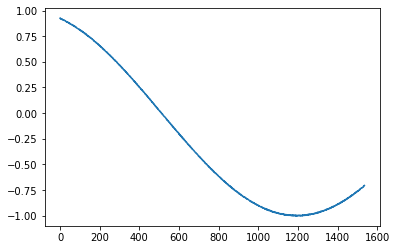

In [26]:
plt.plot(H_known_ofdm)

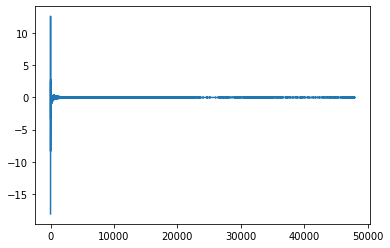

In [27]:
# estimate with method 3
chirp_received = received_signal[event[0]:event[0]+chirp_duration*fs]
reverse_chirp = chirp[::-1]
estimate = channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=fs)

#plt.plot(np.abs(np.fft.fft(estimate)[:20000]))
#plt.title('method 3 estimation '+filename)
h = estimate
H = np.fft.fft(h)
plt.plot(h)

C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'method 1 estimation ofdm_tester')

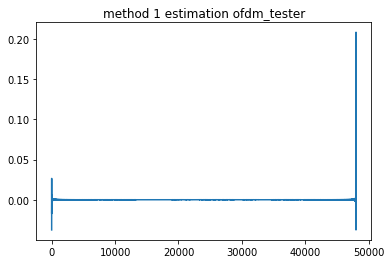

In [28]:
#estimate with method 1, direct division, don't know what's wrong
Y = np.fft.fft(chirp_received)
X = np.fft.fft(chirp)
H = np.divide(Y[:10000],X[:10000])

h = (np.fft.ifft(H, n=chirp_duration*fs))  #estimated channel
#H_trimmed = np.divide(Y,X)[:20000]

plt.plot(h)
plt.title('method 1 estimation '+filename)

In [29]:
# ofdm_start = int(event[0] + fs*(chirp_duration)) #need to change accordingly
# ofdm_end = int(event[1]-1)

ofdm_start = int(known_ofdm_end)
ofdm_end = int(event[1])
received_ofdm =received_signal[ofdm_start:ofdm_end]  #received ofdm information

#might have synchronization problem so recieved length might not be correct, pad with zero for now... don't know if correct
spb = ofdm.subcarriers_per_block(fs,DFT_LENGTH,low_freq, high_freq)
symbols = np.ceil(ofdm_end-ofdm_start)/spb
pad = np.zeros(int(symbols*spb-(ofdm_end-ofdm_start)))
received_ofdm = np.append(received_ofdm,pad )
print(received_ofdm.size/spb)

96.0


In [30]:
#ofdm_size = 147456 #size of ofdm = symbol number * (dft+cp)length
fft = ofdm.ofdm_to_fourier(received_ofdm, DFT_LENGTH, CP_LENGTH)
discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
deconvolved = ofdm.deconvolve(discarded, H_known_ofdm, DFT_LENGTH, fs, low_freq, high_freq)

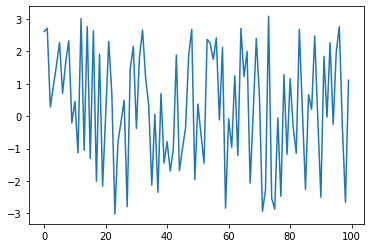

In [31]:
plt.plot(np.angle(deconvolved[:100]))
mdic = {"deconvolved":deconvolved}
scipy.io.savemat('deconvolved.mat',mdic)

In [32]:
#check accuracy
new = True
if new:
    np.random.seed(2)
    encoded = np.random.randint(2, size=1 * fs)
    np.savetxt('encoded', encoded, fmt='%i')


In [33]:
if encode_method == 'qpsk':
    decoded = decode.qpsk_decode(deconvolved)
elif encode_method == 'bpsk':
    decoded = decode.bpsk_decode(deconvolved)
print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])

48000 49152
source:
 [0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1]
decoded:
 [0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1]


In [34]:
print(encoded.size,decoded.size)

48000 49152


In [35]:
equality = encoded == decoded[:encoded.size]
#equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

correct rate:
 0.5993541666666666
